In [21]:
library(hgu133plus2.db)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(dplyr)
library(limma)
library(ggplot2)
library(pheatmap)
library(affy)
library(readxl)
library(viridis)

Loading required package: viridisLite



In [33]:
# Cargar la matriz de expresión
expr_file <- "/home/mlopez/Desktop/alzheimer/data/GSE28148/GSE28146_series_matrix.txt.gz"
raw_data <- read.delim(gzfile(expr_file), comment.char = "!", header = TRUE, row.names = 1)

# Cargar los metadata
metadata <- read.csv("/home/mlopez/Desktop/alzheimer/results/GSE28146/GSE28146_metadata.csv", stringsAsFactors = FALSE)
rownames(metadata) <- metadata$Accession

# Asegúrate de que el orden de columnas en `raw_data` coincida con el orden de muestras en `metadata`
all(colnames(raw_data) == metadata$Accession)  # debe ser TRUE

# Si no es TRUE, puedes reordenar así:
raw_data <- raw_data[, metadata$Accession]

[1] TRUE

In [34]:
# Mapear las sondas a símbolos de genes
symbols <- mapIds(hgu133plus2.db,
                  keys = rownames(raw_data),
                  column = "SYMBOL",
                  keytype = "PROBEID",
                  multiVals = "first")

# Puedes añadir esta información a tus resultados de expresión diferencial
raw_data$Symbol <- symbols[rownames(raw_data)]

'select()' returned 1:many mapping between keys and columns



In [35]:
expr_data <- raw_data
expr_data <- expr_data[!is.na(expr_data$Symbol), ]

In [36]:
expr_by_gene <- expr_data %>%
  group_by(Symbol) %>%
  summarise(across(where(is.numeric), mean)) %>%
  as.data.frame()

# Opcional: poner los símbolos como rownames y quitar la columna "Symbol"
rownames(expr_by_gene) <- expr_by_gene$Symbol
expr_by_gene$Symbol <- NULL

In [37]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE28146/boxplot_raw_expr_GSE28146.pdf")
boxplot(expr_by_gene, 
        main = "Expresión por muestra (antes de normalizar)", 
        las = 2, 
        col = "lightblue", 
        outline = FALSE)
dev.off()

pdf 
  2

In [38]:
#normalizamos los datos
expr_matrix <- as.matrix(expr_by_gene)
norm_expr <- normalizeBetweenArrays(expr_matrix, method = "quantile")

In [39]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE28146/boxplot_norm_expr_GSE28146.pdf")
boxplot(norm_expr, 
        main = "Expresión por muestra (después de normalizar)", 
        las = 2, 
        col = "lightgreen", 
        outline = FALSE)
dev.off()

pdf 
  2

In [40]:
# Calcula la varianza de cada gen (columna)
gene_variance <- apply(norm_expr, 1, var)

# Filtra genes con varianza mayor que 0.01 (ajusta el umbral si es necesario)
norm_exprs_filtered <- norm_expr[gene_variance > 0.01, ]

# Realiza PCA sobre los datos filtrados
pca_result <- prcomp(t(norm_exprs_filtered), scale. = TRUE)

# Extraer los primeros dos componentes principales
pca_data <- data.frame(PC1 = pca_result$x[, 1], PC2 = pca_result$x[, 2], Group = metadata$DiseaseStatus)

# Graficar los primeros dos componentes principales
pdf("/home/mlopez/Desktop/alzheimer/results/GSE28146/pca_norm_expr_GSE28146.pdf")
ggplot(pca_data, aes(x = PC1, y = PC2, color = Group)) +
  geom_point(size = 3) +
  labs(title = "PCA de Expresión Génica Normalizada", x = "Componente Principal 1", y = "Componente Principal 2") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "green", "red", "orange"))
dev.off()

pdf 
  2

In [41]:
# Filtra metadata y expresión para conservar solo muestras con Alzheimer
alz_idx <- metadata$DiseaseStatus %in% c("Incipient", "Moderate", "Severe")
alz_exprs <- norm_expr[, alz_idx]
alz_meta <- metadata[alz_idx, ]

# Define grupo como factor ordenado
group <- factor(alz_meta$DiseaseStatus, levels = c("Incipient", "Moderate", "Severe"))

design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

fit <- lmFit(alz_exprs, design)

contrast.matrix <- makeContrasts(
  Moderate_vs_Incipient = Moderate - Incipient,
  Severe_vs_Incipient = Severe - Incipient,
  Severe_vs_Moderate = Severe - Moderate,
  levels = design
)

fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

In [42]:
topTable(fit2, adjust.method = "fdr", number = Inf)

,Moderate_vs_Incipient,Severe_vs_Incipient,Severe_vs_Moderate,AveExpr,F,P.Value,adj.P.Val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VN1R108P,-89.497225,-94.087032,-4.589808,52.83418,11.938093,0.0003754413,0.9885731
DDR1,33.694532,671.830366,638.135833,1086.05449,11.935249,0.0003759316,0.9885731
SPARC,732.567605,2151.967693,1419.400088,3802.52882,11.262302,0.0005144780,0.9885731
ATOX1,-181.510675,-185.561476,-4.050800,117.65272,11.095403,0.0005569596,0.9885731
AQP1,-53.125821,435.017525,488.143346,890.40067,11.090214,0.0005583409,0.9885731
IGSF6,151.435224,-49.954713,-201.389937,484.01807,10.562027,0.0007207534,0.9885731
NAT8L,-203.550960,343.956939,547.507899,854.99237,10.411429,0.0007761076,0.9885731
CST13P,12.688219,113.648507,100.960287,95.08127,10.385527,0.0007860911,0.9885731
SPAST,-132.815272,-182.648088,-49.832817,307.74196,10.249161,0.0008410320,0.9885731


In [43]:
# Crea un nuevo factor: Alzheimer vs Control
alz_vs_ctrl <- ifelse(metadata$DiseaseStatus == "Control", "Control", "Alzheimer")
alz_vs_ctrl <- factor(alz_vs_ctrl, levels = c("Control", "Alzheimer"))

# Filtra la matriz de expresión para estas muestras
exprs_filtered <- norm_expr[, metadata$DiseaseStatus %in% c("Control", "Incipient", "Moderate", "Severe")]
alz_vs_ctrl <- alz_vs_ctrl[metadata$DiseaseStatus %in% c("Control", "Incipient", "Moderate", "Severe")]

# Modelo de diseño
design2 <- model.matrix(~0 + alz_vs_ctrl)
colnames(design2) <- levels(alz_vs_ctrl)

# Ajuste del modelo
fit_ctrl <- lmFit(exprs_filtered, design2)

# Contraste Alzheimer vs Control
contrast2 <- makeContrasts(Alzheimer_vs_Control = Alzheimer - Control, levels = design2)

# Aplicar contraste y estadística moderada
fit2_ctrl <- contrasts.fit(fit_ctrl, contrast2)
fit2_ctrl <- eBayes(fit2_ctrl)

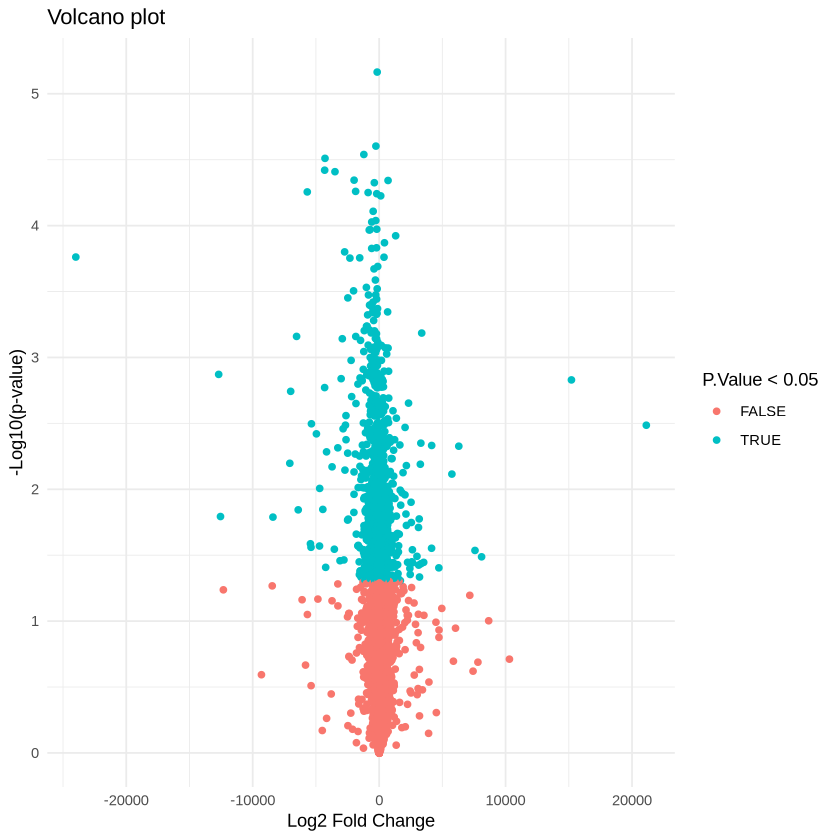

In [44]:
# Volcán plot para visualizar los resultados
results <- topTable(fit2_ctrl, adjust = "fdr", sort.by = "logFC", number = Inf)
ggplot(results, aes(x = logFC, y = -log10(P.Value)) ) +
  geom_point(aes(color = P.Value < 0.05), size = 1.5) +
  theme_minimal() +
  labs(title = "Volcano plot", x = "Log2 Fold Change", y = "-Log10(p-value)")

In [45]:
write.csv(results, file = "/home/mlopez/Desktop/alzheimer/results/GSE28146/dif_expr_results_GSE28146.csv", row.names = TRUE)

In [22]:
AD_T4_targets <- read_excel("/home/mlopez/Desktop/alzheimer/data/AD_T4_targets.xlsx")

New names:
• `` -> `...1`


In [29]:
AD_T4_exp <- na.omit(results[AD_T4_targets$Prot,])

In [46]:
AD_T4_exp$adj.P.Val < 0.05

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE